# MNIST Digit Classification using a Convolutional Neural Network

### 1. Introduction and Goal Definition

*   **The Problem:** This notebook aims to build and train a Convolutional Neural Network (CNN) to accurately classify handwritten digits from the well-known MNIST dataset.
*   **The Dataset:** The MNIST dataset consists of 60,000 training images and 10,000 testing images of handwritten digits (0-9), each of size 28x28 pixels.
*   **The Goal:** The primary objective is to design a model that achieves high classification accuracy (aiming for over 99.4%) on the test set while keeping the model lightweight (under 20,000 parameters). This is a common challenge in deploying models to resource-constrained environments.

# Import Libraries
This cell imports the necessary libraries for building and training the neural network. We import `torch` for tensor operations, `torch.nn` for building neural network layers, `torch.optim` for optimization algorithms, and `torchvision` for datasets and image transformations.

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### 2. Configuration and Hyperparameters

This cell groups all the key hyperparameters and settings in one place. This is a crucial practice for readability and makes it easy to experiment with different values without searching through the entire notebook.

*   **`EPOCHS`**: The number of times the model will see the entire training dataset.
*   **`BATCH_SIZE`**: The number of training samples to process before the model's parameters are updated.
*   **`LEARNING_RATE`**: Controls how much to change the model in response to the estimated error each time the model weights are updated.
*   **`MOMENTUM`**: Helps accelerate SGD in the relevant direction and dampens oscillations.
*   **`USE_CUDA` and `DEVICE`**: Checks if a GPU is available and sets the device for training accordingly to speed up computations.

In [3]:
# Configuration
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = torch.cuda.is_available()
has_xpu_attr = getattr(torch, "xpu", None) is not None
USE_XPU = bool(has_xpu_attr and torch.xpu.is_available())
if USE_XPU:
    DEVICE = torch.device("xpu")
elif USE_CUDA:
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print("Using device:", DEVICE)

Using device: xpu


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.05)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.05)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.05)
        ) # output_size = 8

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(8)
        ) # output_size = 1

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = self.convblock6(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### 3. Define the Neural Network Architecture

This cell defines the neural network architecture. The model is designed to be lightweight and efficient, using several key concepts:

*   **Why Convolutional Layers?** CNNs are the industry standard for computer vision tasks. They are designed to automatically and adaptively learn spatial hierarchies of features from images, from simple edges in the first layers to complex patterns in deeper layers.
*   **Why Batch Normalization?** Batch Normalization is a crucial technique for training deep networks. It normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. This stabilizes the learning process, accelerates training, and can also act as a regularizer, reducing the need for other regularization techniques like dropout.
*   **Why Dropout?** Dropout is a powerful regularization technique to prevent overfitting. During training, it randomly sets a fraction of neuron activations to zero at each update step. This forces the network to learn more robust features and prevents neurons from co-adapting too much.
*   **Why Global Average Pooling (GAP)?** Instead of a traditional fully connected layer, we use GAP at the end of the network. GAP takes the average of each feature map and feeds the resulting vector directly into the softmax layer. This has two major benefits:
    1.  It drastically reduces the number of parameters in the model, which helps to prevent overfitting and makes the model much lighter.
    2.  It is more native to the convolution structure and enforces correspondences between feature maps and categories.

In [16]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(DEVICE)
if DEVICE.type == "xpu":
    print("Torchsummary does not support XPU, using CPU for summary and then moving back to XPU.")
    # Temporarily move model to CPU for summary
    model_cpu = model.cpu()
    summary(model_cpu, input_size=(1, 28, 28), device="cpu")
    # Move model back to XPU
    model = model_cpu.to(DEVICE)
else:
    summary(model, input_size=(1, 28, 28), device=DEVICE.type)

Torchsummary does not support XPU, using CPU for summary and then moving back to XPU.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
       BatchNorm2d-6           [-1, 32, 24, 24]              64
              ReLU-7           [-1, 32, 24, 24]               0
           Dropout-8           [-1, 32, 24, 24]               0
         MaxPool2d-9           [-1, 32, 12, 12]               0
           Conv2d-10           [-1, 16, 12, 12]           4,608
      BatchNorm2d-11           [-1, 16, 12, 12]              32
             ReLU-12           [-1, 16, 12, 12]               0
           Conv2d

# Model Summary
This cell prints a summary of the model architecture, showing the layers, output shapes, and the number of parameters. This is useful for verifying the model structure and checking the parameter count.

In [17]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

### Data Loading and Train/Test Split
This cell is responsible for loading the MNIST dataset and splitting it into training and testing sets.

- **`datasets.MNIST`**: This function from `torchvision` downloads and loads the MNIST dataset. We create two instances: one for training (`train=True`) and one for testing (`train=False`).
- **`transforms.Compose`**: This is used to apply a sequence of transformations to the data.
  - **`transforms.ToTensor()`**: Converts the images from PIL Image format to PyTorch Tensors.
  - **`transforms.Normalize()`**: Normalizes the tensor image with a given mean and standard deviation. Normalization helps the model to converge faster. The values `(0.1307,)` and `(0.3081,)` are the pre-computed mean and standard deviation for the MNIST dataset.
- **`torch.utils.data.DataLoader`**: This wraps the dataset and provides an iterable over it. It handles batching, shuffling, and loading data in parallel.
  - **`batch_size`**: The number of samples per batch.
  - **`shuffle=True`**: Randomly shuffles the data at every epoch. This is important for training to ensure that the model does not learn the order of the training data.
  - **`num_workers`**: The number of subprocesses to use for data loading.
  - **`pin_memory`**: If `True`, the data loader will copy tensors into CUDA pinned memory before returning them, which can speed up data transfer to the GPU.

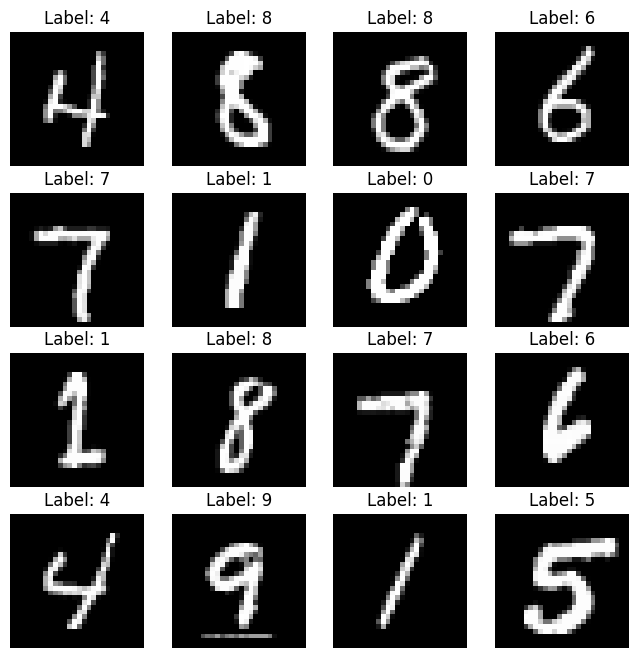

In [18]:
import matplotlib.pyplot as plt

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.show()

### 4. Visualizing the Data

Before we train the model, it's a good practice to visualize a few samples from the dataset. This serves as a sanity check to ensure our data is loaded and processed correctly and gives us an intuition for the task.

# Data Loading and Preprocessing
This cell sets up the data loaders for the MNIST dataset. It includes transformations to convert the images to tensors and normalize them. The data is split into training and test sets.

In [19]:
from tqdm import tqdm
train_losses = []
train_acc = []
test_losses = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Training and Testing Functions
This cell defines the `train` and `test` functions.
- **`train` function:** This function iterates over the training data, performs forward and backward passes, and updates the model parameters.
- **`test` function:** This function evaluates the model on the test data and prints the test loss and accuracy.

In [20]:

model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.011, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.08900848031044006 Batch_id=468 Accuracy=86.21: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]



Test set: Average loss: 0.1207, Accuracy: 9705/10000 (97.05%)

EPOCH: 1


Loss=0.068975068628788 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]   



Test set: Average loss: 0.1258, Accuracy: 9632/10000 (96.32%)

EPOCH: 2


Loss=0.033326033502817154 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]



Test set: Average loss: 0.0449, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.06384145468473434 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s] 



Test set: Average loss: 0.0388, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.021014504134655 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]   



Test set: Average loss: 0.0409, Accuracy: 9885/10000 (98.85%)

EPOCH: 5


Loss=0.04639267921447754 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]  



Test set: Average loss: 0.0345, Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.014346080832183361 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.82it/s] 



Test set: Average loss: 0.0272, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.023951202630996704 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s] 



Test set: Average loss: 0.0297, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.0033662086352705956 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]



Test set: Average loss: 0.0277, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.0071935467422008514 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 31.06it/s]



Test set: Average loss: 0.0265, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.015393897891044617 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s] 



Test set: Average loss: 0.0235, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.0232155192643404 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]   



Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.023921534419059753 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s] 



Test set: Average loss: 0.0228, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.019444718956947327 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s] 



Test set: Average loss: 0.0247, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.007540947292000055 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s] 



Test set: Average loss: 0.0244, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.00282199471257627 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]  



Test set: Average loss: 0.0232, Accuracy: 9919/10000 (99.19%)

EPOCH: 16


Loss=0.03786000236868858 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]  



Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.02046280726790428 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:15<00:00, 31.01it/s]  



Test set: Average loss: 0.0203, Accuracy: 9944/10000 (99.44%)

EPOCH: 18


Loss=0.007056306581944227 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s] 



Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.024181397631764412 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:15<00:00, 30.66it/s] 



Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)



# Model Training
This cell initializes the model and the optimizer, and then trains the model for a specified number of epochs. The `train` and `test` functions are called in a loop to train the model and evaluate its performance after each epoch.

Text(0.5, 1.0, 'Test Accuracy')

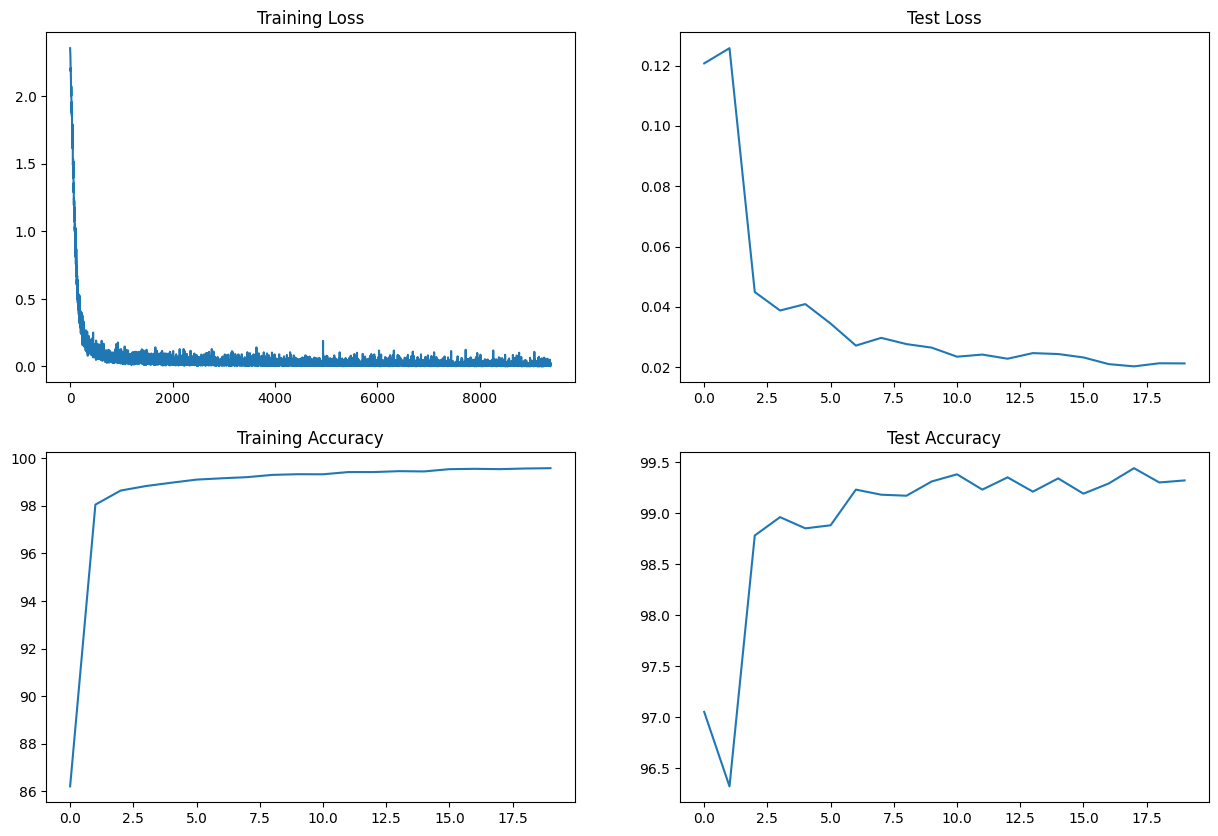

In [21]:
!pip install matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Plotting Results
This cell plots the training and testing loss and accuracy over the epochs. This is a standard way to visualize the performance of a machine learning model.
- **Training Loss:** Should decrease over time, indicating that the model is learning from the training data.
- **Training Accuracy:** Should increase over time, indicating that the model is getting better at classifying the training data.
- **Test Loss:** Should also decrease over time, but if it starts to increase while the training loss is still decreasing, it's a sign of overfitting.
- **Test Accuracy:** This is the primary metric for evaluating the model's performance on unseen data. It should increase and then plateau.

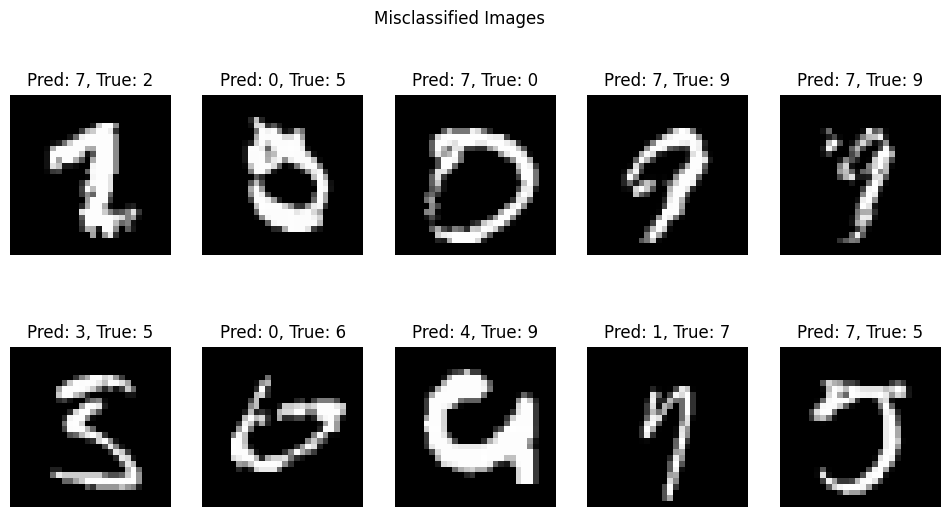

In [22]:
# Find and plot misclassified images
model.eval()
misclassified_images = []
misclassified_labels = []
correct_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        misclassified_mask = (pred.eq(target.view_as(pred)) == False).squeeze()
        
        misclassified_images.extend(data[misclassified_mask])
        misclassified_labels.extend(pred[misclassified_mask])
        correct_labels.extend(target.view_as(pred)[misclassified_mask])

# Plot some misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Misclassified Images")
for i, ax in enumerate(axes.flat):
    if i < len(misclassified_images) and i < 10: # Plot up to 10 misclassified images
        ax.imshow(misclassified_images[i].cpu().squeeze(), cmap='gray')
        ax.set_title(f"Pred: {misclassified_labels[i].item()}, True: {correct_labels[i].item()}")
        ax.axis('off')
plt.show()

### 6. Visualizing Misclassifications

While overall accuracy is a good measure, it's often more insightful to analyze where the model is making mistakes. This is a critical step in industry for model improvement. By looking at the images the model gets wrong, we can gain insights into its weaknesses. For example, does it consistently confuse certain pairs of digits (like '4' and '9', or '7' and '1')? This analysis can guide further improvements, such as data augmentation or architectural changes.